

In this notebook we build upon fermion_spin_hopping_qutip to try and build a QPC meassuring a single/double dot system. Here, we model the QPC as a thighbinding model with equal hopping everywhere except where its is hooked up to the double dot system via a quartic interaction. 

**This chain should be long enough that the wave packet does not bounce back before we see events in the double dot system**.

The double dot is isolated and we are also not considering dephasing anywhere. For this reason, **it may be better to use some Schrödinger equation solver rather than the full Lindbladian**. 


In [30]:
import numpy as np

from scipy.fft import fft, fftfreq, fftshift
from scipy.integrate import simpson
from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns
from qutip import  *
import os
import sys
import h5py
import json

import matplotlib

# add path to project dir so we can include custom modules from src
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

sys.path.insert(0, parent_path)

from scripts.qutip_tools import *


In [31]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 18

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/QPC_double_dot/"


In [32]:
def gen_gauss_init(l0, sigma, Nsites, k0=0):
    # creates a gaussian initial condition centerd on l0 with bandwidth sigma for Nsites
    # and initial velocity k0

    x = np.asarray(range(0,Nsites))
    coefs = ((np.sqrt(np.pi)*sigma)**(-0.5))*np.exp(-0.5*(x-l0)**2/(sigma**2) )*np.exp(1j*k0*(x-l0))
    
    # normalize
    mag = np.dot(np.conjugate(coefs),coefs)
    coefs = coefs/np.sqrt(mag)
    
    return coefs   



In [33]:
def get_qpc_H(op_list, Nsites, Nqpc,jcouple):
    # create the Hamiltonian for the QPC where Nsites includes the double dot
    # and Nqpc only has the qpc site
    ident_tensor = tensor([identity(2)]*(Nsites)) 
    H = 0*ident_tensor

    for site_j in range(0,Nqpc-1):
        H += -jcouple[site_j]*(op_list[site_j].dag()*op_list[site_j+1]+
                                   op_list[site_j+1].dag()*op_list[site_j])
    return H 
    
def gen_QPC_dot_basis(L_QPC, Center_index, Band_w, Kinit, DD0):
    # Combines the 1particle bassi of the QPC and the dot to get the full psi

    # L_QPC: integer, length of qpc lattice
    # Center_index: integer, indicates the lattice site where QPC is initialized
    # Band_w: float, band width of the gaussian qave packet in the qpc
    # Kinit: float, group velocity of the gaussian wave packet
    # DD0: string, tells dot initial condition either "first" or "second"

    # create the 1 particle basis and the coeficients for the initial state
    str_list, basis_list = get_1p_basis(L_QPC)
  
    # build the initial condition for the QPC
    qpc_init = gen_gauss_init(Center_index, Band_w, L_QPC, Kinit)

    psi_qpc = [qpc_init[j]*basis_list[j] for j in range(0,len(qpc_init))]
    
    # make sure these stay as sparse matrices
    b1 = basis(2,0)
    b1.data = data.to(data.CSR, b1.data)
    
    b2 = basis(2,1)
    b2.data = data.to(data.CSR, b2.data)
    
    # create the dot basis
    dot_basis = [tensor(b1,b2), tensor(b2,b1)]
    
    # build the initial condition for the dot
    if DD0 == "first": 
        dot_init = [1.0, 0.0]
    elif DD0 == "second": 
        dot_init = [0.0, 1.0]
    elif DD0 == "fixed":
        a0, b0 = get_DD_init_for_fixed_k(Kinit)
        dot_init = [a0,b0]
    else:
        print("Invalid initial condition for the double dot")

    psi_dot = [dot_basis[j]*dot_init[j] for j in range(0,len(dot_basis))]
    # assume dot initial state completely independent from QPC init state so we can factorize the probas
    full_basis = []
    # combine them 
    for i in range(0,len(basis_list)):
        for j in range(0, len(dot_basis)):
            full_basis.append(tensor([psi_qpc[i], psi_dot[j]]))

    # state correspond to particle in qpc all the way to the left and particle on left dot
    Psi0 = np.sum(full_basis)
    Psi0 = Psi0.unit()   
    # Psi0.data = data.to(data.CSR, Psi0.data)
    return Psi0, qpc_init
    
def get_partial_trace(Psi,NN):
    # calcualtes the partial trace from a STATEVECTOR Psi
    # NOT from the density matrix
    # Psi: Quobject from Qutip representing the wavefunction
    # NN: integer with the total size of the lattice

    n = 2**(NN-2) # QPC sites
    m = 2**2 # Double dot sites
    # get density matrix as a sparse array
    ps = sparse.csr_matrix(Psi.full())
    A = sparse.kron(ps, np.conj(ps.T))
    # convert to normal array for partial trace operation
    Adense = A.toarray()
    # trace out QPC sites and return reduced rho for DD as Quobject
    return Qobj(np.trace(Adense.reshape(n,m,n,m), axis1=0, axis2=2))


def get_DD_init_for_fixed_k(k_prime):
    # calculated the initial conditions of the DD such that, when the QPC hits the bond
    # its state is the same as that of a DD initialized localized in the first site when 
    # the QPC for that case hits the bond with an average momentum k0=pi/2
    # k_prime: float. The momentum of the qpc particle
     
    alpha0 = np.cos( (t*bond_index)/(2*J[0])*(1/np.sin(k_prime) - 1) )
    beta0 = - 1j*np.sin( (t*bond_index)/(2*J[0])*(1/np.sin(k_prime) - 1) )
                        
    return alpha0, beta0
    

In [34]:
int(15/2)

7

In [45]:
bond_index

2

In [35]:
2*7*4*2

112

In [36]:
# location where the raw data is saved
data_route = "../data/sims/"
fig_route = "../plots/QPC_double_dot/"

L_qpc = 4  # lenth of the QPC chain
L = L_qpc+2 # QPC times double dot 
max_t = 9 # maximum time
tsteps = 300 # number of time steps
bond_index = int(L_qpc/2) # dangling bond between bond_index and bond_index+1
centered_at = 0 # initial QPC position of wavepacket
band_width = 2.0 # width of the gaussian wave packet larger bandwidth means less lattice localizaiton
K0 = np.pi/2 # averga momentum of the wavepacket
J_prime = 1.0 # contact to double dot
t = 0.2 # hopping between quantum dots 
Omega = 0.5 # coupling between dot 1 and QPC
ddot = "fixed" # can be first (localized in 1st site), second (loc in 2nd) or fixed (fixed by K0)
gamma=0
# dot energies not yet implemented
E1 = 0.0
E2 = 0.0
epsilon = np.zeros(L_qpc) # energies of the QPC chains 

epsilon[:bond_index] = 0.0 # source energies
epsilon[bond_index:] = 0.0 # drain energies
J = np.ones(L_qpc) # QPC hopping
# this means that I am putting the dangling bond between sites int(L_qpc/2) and int(L_qpc/2)+1
# where the interaction to the double dot is also located
J[bond_index] = J_prime  


## Initial conditions

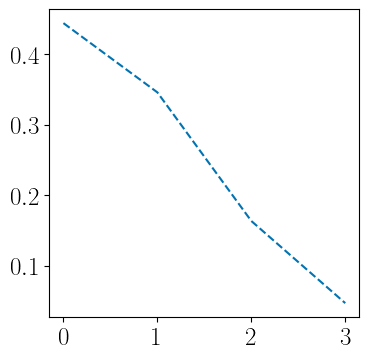

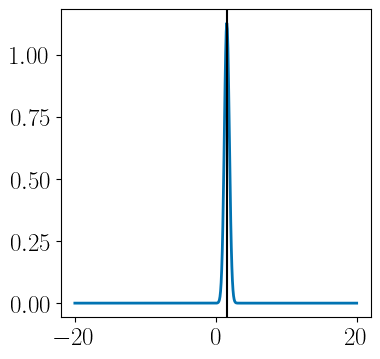

In [37]:
psi0, qpc_init = gen_QPC_dot_basis(L_qpc, centered_at, band_width, K0, ddot)
# create the fermion operator list
c_list = [fdestroy(L,i) for i in range(0,L)]

# we can also calcualte the fourier transform of the initial gaussian to see
# the momentum distribution
k_arr = np.linspace(-20,20,500)
Psi0k = (band_width**2/np.pi)**(1/4)*np.exp(-(0.5*band_width**2)*(k_arr-K0)**2 + 1j*k_arr*centered_at)

# visualize the initial condition of the qpc
fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(range(0,L_qpc),np.abs(qpc_init)**2, linestyle = "dashed")

fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(k_arr,np.abs(Psi0k)**2, linestyle = "solid", linewidth=2)
ax.axvline(K0,c='black')

## Solution

In [38]:
# create the hamiltonian start with qpc
H_QC = get_qpc_H(c_list, L ,L_qpc,J)

# double dot H
Hdot = -t*(c_list[-1].dag()*c_list[-2] + c_list[-2].dag()*c_list[-1])

# interaction H
Hint =  Omega*c_list[-2].dag()*c_list[-2]*( c_list[bond_index].dag()*c_list[bond_index+1] +
                                          c_list[bond_index+1].dag()*c_list[bond_index])

H = H_QC + Hdot  + Hint

print(H_QC.isherm, Hdot.isherm, Hint.isherm, H.isherm)

# get the operators needed for lindbladian 
# hrtr we don't really want dephasing but just put it there for now
collapse_ops, expect_ops = create_lindblad_op(L, c_list, gamma)
# add the energy to also track it
expect_ops.append(H)

times = np.linspace(0.0, max_t, tsteps)
# solve for operators
result = sesolve(H, psi0, times, e_ops=expect_ops,options={"store_states": True})
# solve for state
# result_psi = sesolve(H, psi0, times)

print(result)



True True True True
<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.00012922286987304688
    preparation time: 0.0005362033843994141
    run time: 0.04631972312927246
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 9.0] (300 steps)
  Number of e_ops: 7
  States saved.
>


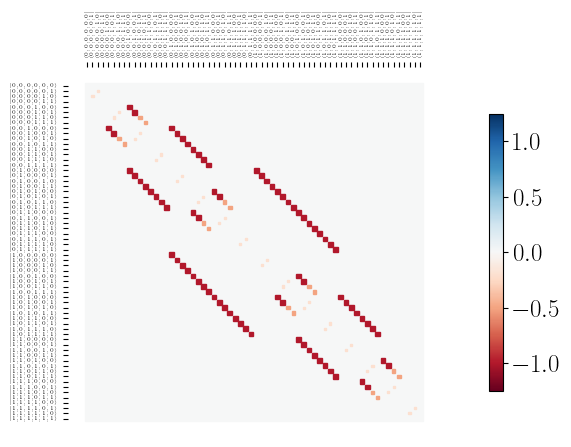

In [41]:
"""# for plotting SMALL Hamiltonians
fig, ax = hinton(H)
ax.tick_params(axis='both', which='major', labelsize = 4)
ax.tick_params(axis='x', rotation=90)
# plt.savefig("H.png", dpi =500)"""

In [ ]:
# exclude the sites at Lp/2 and Lp/2 +1 where the bond is located
n_left = np.sum(result.expect[:bond_index], axis=0)
# the minus 3 is because we  leave out the energy and dot occupations
n_right = np.sum(result.expect[bond_index+2:-3], axis=0)
# occupation in the bond
n_bond = result.expect[int(bond_index)] + result.expect[bond_index+1] 


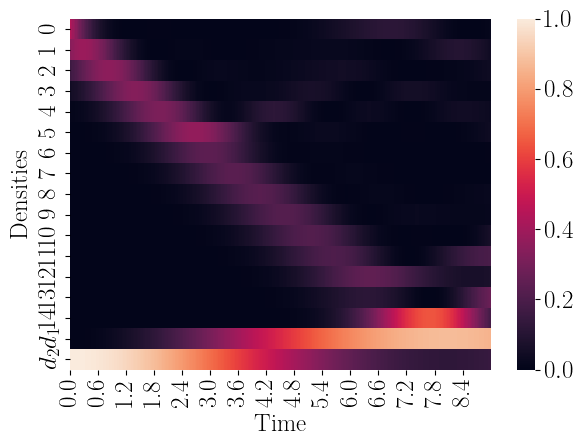

In [19]:
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1],)
ax.set_xlabel("Time")
ax.set_ylabel("Densities")

# plot time or arrival in index coordinates
delta_tau = times[1]- times[0]

#ax.axhspan(param_dict["bond_index"], param_dict["bond_index"], alpha=0.5)

# lattice ticks
site_ticks = list(range(0,L_qpc)) + [r"$d_1$",r"$d_2$"]
tick_posy = np.asarray(range(0,len(site_ticks))) + 0.5
ax.set_yticks(tick_posy,site_ticks);

# time ticks
tick_posx = np.arange(0,len(times),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)
ax.set_xticks(tick_posx,xtick_label);

plt.tight_layout()

# Comparisson with the decoupled case

##  Exact $\psi$ in the QPC

Taken from: https://physics.stackexchange.com/questions/709973/open-boundary-condition-in-hubbard-model

The eigenbasis of the tight binding QPC Hamiltonian with the double dot interaction is in k-space


In [11]:
k_arr = (np.pi/(L_qpc+1))*np.arange(1,L_qpc+1)
Ek_arr = -2*np.cos(k_arr) # eigenenergies
vk_arr = np.zeros((L_qpc, len(k_arr)))# eigenvalues 
# create the eigenvectors:
for k in range(0,len(k_arr)):
    # first index is lattice site second index are k-momenta
    vk = np.sin(k_arr[k]*np.arange(1,L_qpc+1))
    # normalize 
    mag2 = np.dot(vk,vk)
    vk_arr[:,k] = vk/np.sqrt(mag2)

# express the time evolution of the occupation psi in terms of the eigenvectors by changing basis
psi_t = np.zeros((L_qpc, len(times)),dtype=complex) # first index is lattice site, second is time
psi_t[:,0] = qpc_init

# time evolution
for t_index in range(1,len(times)):
    # basis change
    for k_index in range(0,len(k_arr)):
        tt = times[t_index]
        psi_t[:,t_index] += np.dot(qpc_init,vk_arr[:,k_index])*np.exp(-1j*tt*Ek_arr[k_index])*vk_arr[:,k_index]
   
psi_probas = np.abs(psi_t)**2


## Trajectories

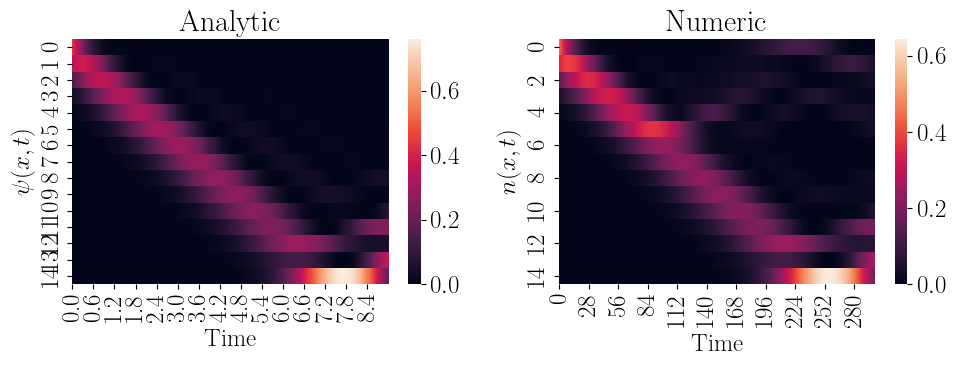

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.heatmap(psi_probas, ax=ax[0])

# ANALYTICAL RESULT
ax[0].set_title("Analytic")
ax[0].set_xlabel("Time")
ax[0].set_ylabel(r"$\psi (x,t)$");

# lattice ticks
site_ticks = list(range(0,L_qpc))
tick_posy = np.asarray(range(0,len(site_ticks))) + 0.5
ax[0].set_yticks(tick_posy,site_ticks);

# time ticks
delta_tau = times[1]- times[0]
tick_posx = np.arange(0,len(times),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)
ax[0].set_xticks(tick_posx,xtick_label);
ax[1].set_xticks(tick_posx,xtick_label);

# NUMERICAL RESULT
sns.heatmap(result.expect[:-3], ax=ax[1])

ax[1].set_title("Numeric")
ax[1].set_xlabel("Time")
ax[1].set_ylabel(r"$n(x,t)$");

plt.tight_layout()
#plt.savefig(fig_route+"decoupled_trajectories_analytic_comp.png")


Text(0, 0.5, '$\\rm{Analytical } \\psi(t) $')

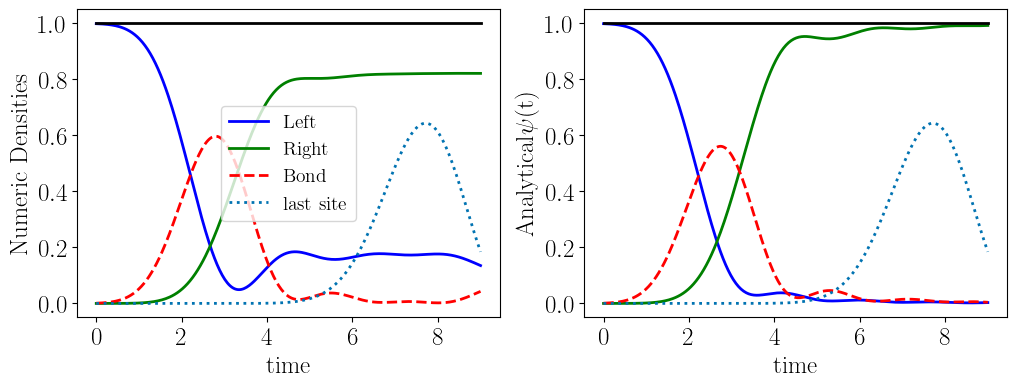

In [13]:
# exclude the sites at Lp/2 and Lp/2 +1 where the bond is located
n_left = np.sum(result.expect[:bond_index], axis=0)
# the minus 3 is because we  leave out the energy and dot occupations
n_right = np.sum(result.expect[bond_index+2:-3], axis=0)
# occupation in the bond
n_bond = result.expect[int(bond_index)] + result.expect[bond_index+1] 

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(times, n_left, label="Left", c='blue', linewidth=2)
ax[0].plot(times,n_right,label="Right", c='green',linewidth=2)
ax[0].plot(times,n_bond,label="Bond", linestyle="dashed", c='red',linewidth=2)
ax[0].plot(times,result.expect[-4],label="last site", linestyle="dotted",linewidth=2)
ax[0].plot(times,n_left+n_right+n_bond, c = 'black',linewidth=2)
ax[0].set_xlabel("time")
ax[0].set_ylabel("Numeric Densities")
ax[0].legend()

# now we do the same but for the analytical results

n_left = np.sum(psi_probas[:bond_index,:], axis=0)
n_right = np.sum(psi_probas[bond_index+2:,:], axis=0)
n_bond = psi_probas[bond_index,:] + psi_probas[bond_index+1,:] 

ax[1].plot(times, n_left, label="Left", c='blue', linewidth=2)
ax[1].plot(times,n_right,label="Right", c='green',linewidth=2)
ax[1].plot(times,n_bond,label="Bond", linestyle="dashed", c='red',linewidth=2)
ax[1].plot(times,result.expect[-4],label="last site", linestyle="dotted",linewidth=2)
ax[1].plot(times,n_left+n_right+n_bond, c = 'black',linewidth=2)
ax[1].set_xlabel("time")
ax[1].set_ylabel(r"$\rm{Analytical } \psi(t) $")


## Rabi Oscillations in the double dot

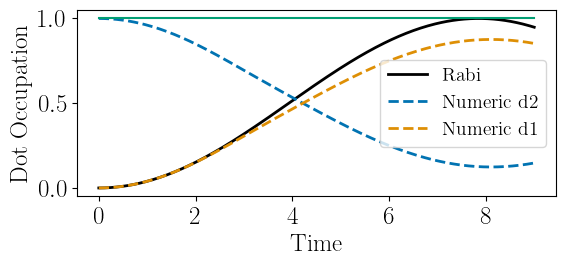

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,3),sharex=True)
wr = t
rabi_osc = np.sin(wr*times)**2

# in dot
ax.plot(times, rabi_osc, linewidth=2.0, alpha=1.0, c='black' ,label="Rabi")
ax.plot(times, result.expect[-2], linewidth=2.0, alpha=1.0, linestyle="dashed" ,
        label="Numeric d2")

ax.plot(times, result.expect[-3], linewidth=2.0, alpha=1.0, linestyle="dashed" ,
        label="Numeric d1")

ax.plot(times, result.expect[-2]+result.expect[-3])

plt.ylabel("Dot Occupation")
plt.xlabel("Time")

plt.legend()
plt.tight_layout()
#plt.savefig(fig_route+"decoupled_rabi_analytic_comp.png")



# Entanglement Meassures

In [15]:
purity_list = []
entropy_list = []
rho_list = []
# skip some times otherwise its too heavy
tskip=20
state_arr = result.states[0::tskip]

for ti in range(0,len(state_arr)):
    # DD reduced density matrix
    # rho_DD = get_partial_trace(state_arr[ti], L_qpc+2)
    # transform to sparse
    state_spa = state_arr[ti]
    state_spa.data = data.to(data.CSR, state_spa.data)
    rho = state_spa*state_spa.dag()
    rho_DD = rho.ptrace(sel=[L-2,L-1])
    # purity
    purity_list.append((rho_DD**2).tr())
    entropy_list.append(entropy_vn(rho_DD, sparse=True))
    rho_list.append(rho_DD)

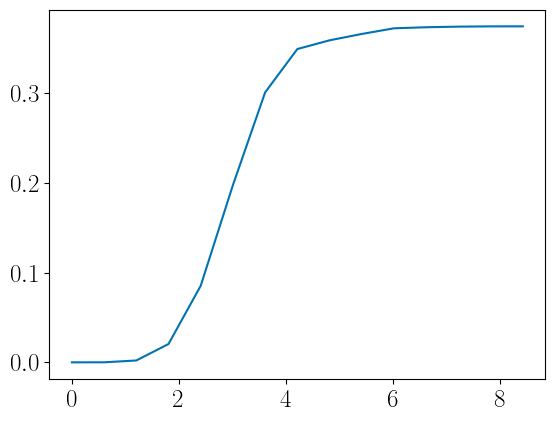

In [16]:
plt.plot(times[0::tskip],entropy_list)

# Bloch Sphere

two ideas: either trace out dot 2 or just isolate the block corresponding to the actual two state system. Remember that here the density matrix of the double dot is not sxs but 4x4 beacuse in each lattice there is an occupied and unoccupied state. For the spinless case this measn that there are surplus degrees of freedom but this will be useul for spin cases.

/var/folders/0k/k5cgw5hd6js31gjfdv_v8h7m0000gr/T/ipykernel_70534/468383623.py:17: RuntimeWarning: invalid value encountered in scalar divide
  phi_p = -np.arccos( 0.5*(Sig_matrix[1,0]+Sig_matrix[0,1])/np.sin(theta_p) )
/var/folders/0k/k5cgw5hd6js31gjfdv_v8h7m0000gr/T/ipykernel_70534/468383623.py:17: RuntimeWarning: invalid value encountered in arccos
  phi_p = -np.arccos( 0.5*(Sig_matrix[1,0]+Sig_matrix[0,1])/np.sin(theta_p) )


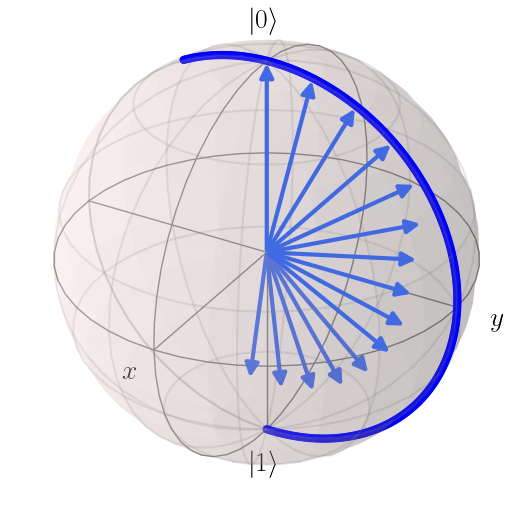

In [17]:
bs = Bloch()

corr_purity_list = []
corr_rho_list = []
theta_list = []
phi_list = []

for i in range(0,len(rho_list)):
     # extract the relevant 2x2 block as a qubit state from the 4x4 double dot density matrix
    r = Qobj(rho_list[i][1:-1,1:-1])
    corr_rho_list.append(r)
    corr_purity_list.append((r**2).tr())
    # we can also find the blocj sphere angles from the numeric rho from the
    # mixed state bloch sphere representation. Check page 34 of my notes for this 
    Sig_matrix = 2*r - identity(2)
    theta_p = np.arccos(Sig_matrix[0,0])
    phi_p = -np.arccos( 0.5*(Sig_matrix[1,0]+Sig_matrix[0,1])/np.sin(theta_p) )
    
    theta_list.append(theta_p)
    phi_list.append(phi_p)

theta_list = np.asarray(theta_list)
phi_list = np.asarray(phi_list)

# now generate the expected free oscillations
w = t
theta_free = 2*w*times
phi_free = -0.5*np.pi

# writting out free case solution in spherical coordinates
x_ = np.sin(theta_free+np.pi)*np.cos(phi_free)
y_ = np.sin(theta_free+np.pi)*np.sin(phi_free)
z_ = np.cos(theta_free+np.pi)
# the + pi in the angle is because we start the system in the 1 state instead of the 0 

psi_points = [x_, y_, z_]
    
bs.vector_color = ["royalblue"]*len(corr_rho_list) 

bs.add_points(psi_points)
bs.add_states(corr_rho_list)

bs.show()


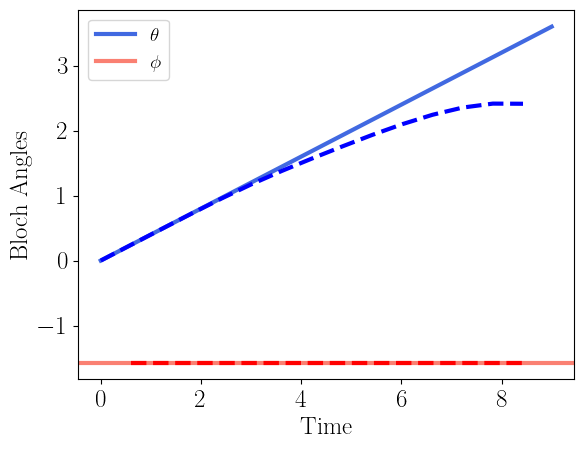

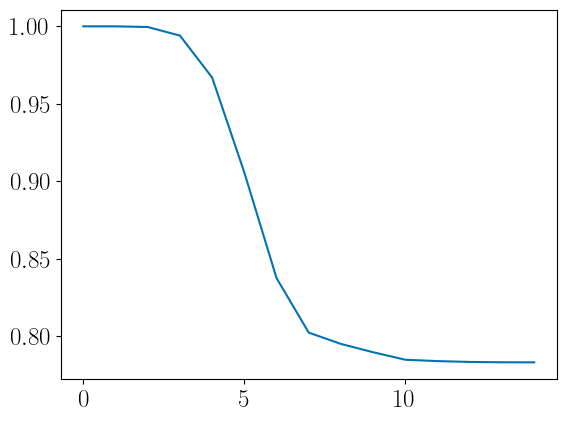

In [18]:
plt.plot(times, theta_free, c='royalblue', linewidth=3, label=r"$\theta$")
plt.axhline(phi_free, c = "salmon",linewidth=3, label=r"$\phi$")
plt.plot(times[::tskip], theta_list.real, c='blue', linestyle="dashed", linewidth=3)

plt.plot(times[::tskip], phi_list.real, c='red', linestyle="dashed", linewidth=3)
plt.legend()
plt.xlabel(r"Time")
plt.ylabel(r"Bloch Angles")

plt.figure()
plt.plot(corr_purity_list)